# Multilayer Perceptron Classifiers

**This notebook shows how to create a MLP classification model with TensorFlow 2 and Keras**

## The Data

We will be using the Wine Quality dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/):

https://archive.ics.uci.edu/ml/datasets/wine+quality

**Information**

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).


**Attributes**

1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol
12. quality (score between 0 and 10)

## Table of Contents
- ### [Python libraries](#libraries)
- ### [Data Exploration and Feature Engineering](#exploration)
- ### [Split the Data](#split)
- ### [Normalize the Data](#normalize)
- ### [Create the Model](#model)
- ### [Train the Model](#training)
    ### [1. Choosing too many epochs and overfit](#overfit)
    ### [2. Add Dropout layers](#dropout)
    ### [3. Early Stopping](#early_stop)
- ### [Evaluate the Model](#evaluation)
- ### [Predictions](#predictions)

<a id='libraries'></a>
## Python libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/Users/ikersanchez/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<a id='exploration'></a>
## Data Exploration and Feature Engineering

**Read the data**

In [2]:
df_red = pd.read_csv('../../Data/winequality-red.csv').drop(columns='Unnamed: 0')
df_red['type'] = 'red'
df_white = pd.read_csv('../../Data/winequality-white.csv').drop(columns='Unnamed: 0')
df_white['type'] = 'white'

df = pd.concat([df_red, df_white])
df.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed.acidity,6497.0,7.215307,1.296434,3.80000,6.40000,7.00000,7.70000,15.90000
volatile.acidity,6497.0,0.339666,0.164636,0.08000,0.23000,0.29000,0.40000,1.58000
citric.acid,6497.0,0.318633,0.145318,0.00000,0.25000,0.31000,0.39000,1.66000
residual.sugar,6497.0,5.443235,4.757804,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6497.0,0.056034,0.035034,0.00900,0.03800,0.04700,0.06500,0.61100
free.sulfur.dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total.sulfur.dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6497.0,3.218501,0.160787,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6497.0,0.531268,0.148806,0.22000,0.43000,0.51000,0.60000,2.00000


**Class balancing**

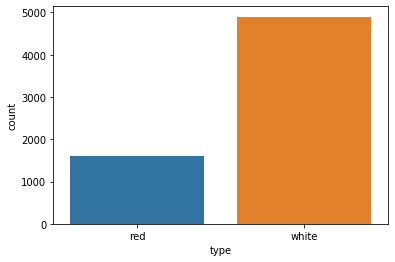

In [4]:
sns.countplot(x='type',data=df)

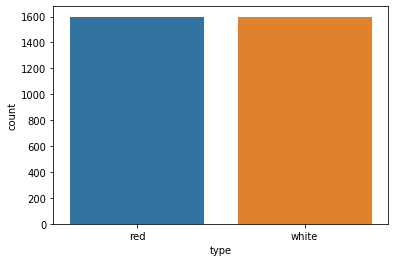

In [6]:
df = df.iloc[:2*len(df_red)]
sns.countplot(x='type',data=df)

Converting categorical data into numbers

In [7]:
dict_cat = dict(zip(df['type'].unique(), np.arange(df['type'].nunique())))
dict_cat

{'red': 0, 'white': 1}

In [8]:
df['type'] = df['type'].apply(lambda x: dict_cat[x])

**Correlations**

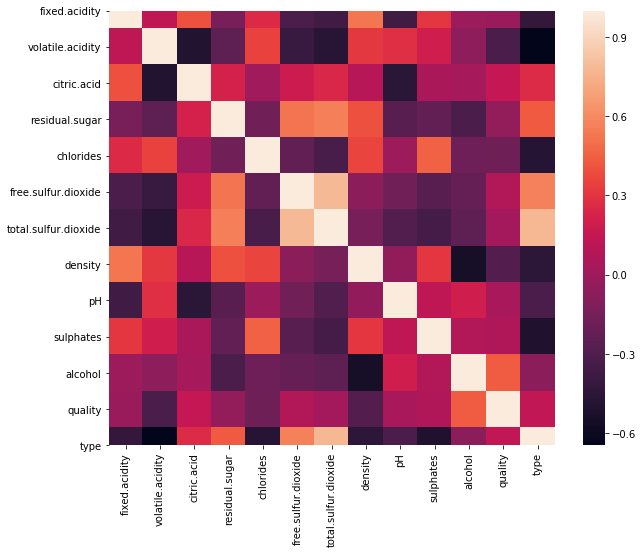

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr())

In [10]:
df.corr()['type'].sort_values()

volatile.acidity       -0.646461
sulphates              -0.506999
chlorides              -0.483965
density                -0.453016
fixed.acidity          -0.427140
pH                     -0.318459
alcohol                -0.062780
quality                 0.135458
citric.acid             0.264041
residual.sugar          0.431283
free.sulfur.dioxide     0.568385
total.sulfur.dioxide    0.780594
type                    1.000000
Name: type, dtype: float64

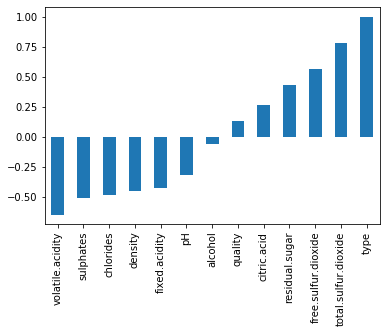

In [11]:
df.corr()['type'].sort_values().plot(kind='bar')

<a id='split'></a>
## Split the Data

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X = df.drop('type',axis=1).values
y = df['type'].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [15]:
X_train.shape

(2398, 12)

In [16]:
y_train.shape

(2398,)

<a id='normalize'></a>
## Normalize the Data

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

In [19]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<a id='model'></a>
## Create the Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [28]:
model = Sequential()

model.add(Dense(40,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

# For a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam')

<a id='training'></a>
## Train the Model

<a id='overfit'></a>
### 1. Choosing too many epochs and overfit

In [29]:
model.fit(x=X_train, y=y_train, 
          validation_data=(X_test,y_test),
          epochs=500)

Train on 2398 samples, validate on 800 samples
Epoch 1/500
2398/2398 [==============================] - 1s 291us/sample - loss: 0.5837 - val_loss: 0.4379
Epoch 2/500
2398/2398 [==============================] - 0s 64us/sample - loss: 0.2896 - val_loss: 0.1654
Epoch 3/500
2398/2398 [==============================] - 0s 64us/sample - loss: 0.1272 - val_loss: 0.0962
Epoch 4/500
2398/2398 [==============================] - 0s 63us/sample - loss: 0.0888 - val_loss: 0.0752
Epoch 5/500
2398/2398 [==============================] - 0s 62us/sample - loss: 0.0742 - val_loss: 0.0659
Epoch 6/500
2398/2398 [==============================] - 0s 72us/sample - loss: 0.0668 - val_loss: 0.0596
Epoch 7/500
2398/2398 [==============================] - 0s 59us/sample - loss: 0.0609 - val_loss: 0.0579
Epoch 8/500
2398/2398 [==============================] - 0s 60us/sample - loss: 0.0574 - val_loss: 0.0519
Epoch 9/500
2398/2398 [==============================] - 0s 47us/sample - loss: 0.0543 - val_loss: 0.050

**Check if the model overfits**

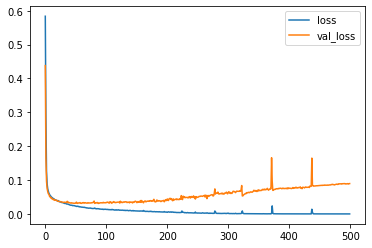

In [30]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

<a id='dropout'></a>
### 2. Add Dropout layers

In [24]:
from tensorflow.keras.layers import Dropout

In [31]:
model = Sequential()
model.add(Dense(40,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(20,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [32]:
model.fit(x=X_train, y=y_train, 
          validation_data=(X_test,y_test),
          epochs=500)

Train on 2398 samples, validate on 800 samples
Epoch 1/500
2398/2398 [==============================] - 1s 292us/sample - loss: 0.6558 - val_loss: 0.5574
Epoch 2/500
2398/2398 [==============================] - 0s 70us/sample - loss: 0.5087 - val_loss: 0.3408
Epoch 3/500
2398/2398 [==============================] - 0s 70us/sample - loss: 0.3321 - val_loss: 0.1732
Epoch 4/500
2398/2398 [==============================] - 0s 65us/sample - loss: 0.2201 - val_loss: 0.1134
Epoch 5/500
2398/2398 [==============================] - 0s 64us/sample - loss: 0.1733 - val_loss: 0.0887
Epoch 6/500
2398/2398 [==============================] - 0s 70us/sample - loss: 0.1516 - val_loss: 0.0794
Epoch 7/500
2398/2398 [==============================] - 0s 79us/sample - loss: 0.1328 - val_loss: 0.0728
Epoch 8/500
2398/2398 [==============================] - 0s 63us/sample - loss: 0.1130 - val_loss: 0.0661
Epoch 9/500
2398/2398 [==============================] - 0s 55us/sample - loss: 0.1118 - val_loss: 0.064

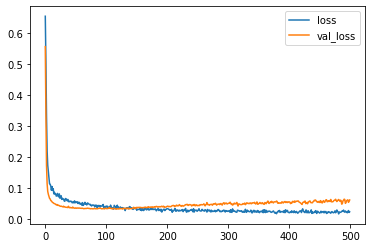

In [33]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

<a id='early_stop'></a>
### 3. Early Stopping

Let's use early stopping to track the val_loss and stop training once it begins increasing too much!

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [36]:
model = Sequential()
model.add(Dense(40,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(20,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [37]:
model.fit(x=X_train, y=y_train, 
          validation_data=(X_test, y_test),
          epochs=500,
          callbacks=[early_stop]
          )

Train on 2398 samples, validate on 800 samples
Epoch 1/500
2398/2398 [==============================] - 1s 305us/sample - loss: 0.6573 - val_loss: 0.6045
Epoch 2/500
2398/2398 [==============================] - 0s 63us/sample - loss: 0.5204 - val_loss: 0.3479
Epoch 3/500
2398/2398 [==============================] - 0s 64us/sample - loss: 0.3338 - val_loss: 0.1702
Epoch 4/500
2398/2398 [==============================] - 0s 80us/sample - loss: 0.2088 - val_loss: 0.1045
Epoch 5/500
2398/2398 [==============================] - 0s 61us/sample - loss: 0.1716 - val_loss: 0.0842
Epoch 6/500
2398/2398 [==============================] - 0s 73us/sample - loss: 0.1296 - val_loss: 0.0746
Epoch 7/500
2398/2398 [==============================] - 0s 73us/sample - loss: 0.1285 - val_loss: 0.0693
Epoch 8/500
2398/2398 [==============================] - 0s 67us/sample - loss: 0.1178 - val_loss: 0.0621
Epoch 9/500
2398/2398 [==============================] - 0s 56us/sample - loss: 0.1077 - val_loss: 0.058

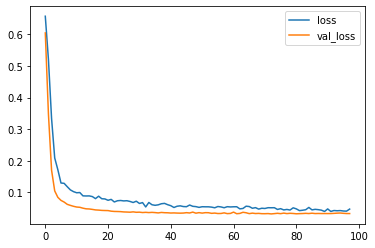

In [38]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

**Save the model**

In [39]:
#model.save('classification_model.h5')

**Load the model**

In [ ]:
#model = load_model('classification_model.h5')

<a id='evaluation'></a>
## Evaluate the Model
Check common classification metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

In [40]:
from sklearn.metrics import classification_report, confusion_matrix

In [41]:
predictions = model.predict_classes(X_test)

**[Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)**

In [42]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       418
           1       0.99      1.00      0.99       382

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



**[Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)**

In [43]:
print(confusion_matrix(y_test,predictions))

[[414   4]
 [  1 381]]


<a id='predictions'></a>
## Predictions

In [44]:
single_wine = df_white.drop('type',axis=1).iloc[-1]
print("True wine type:", df_white['type'].iloc[-1])

True wine type: white


In [45]:
single_wine = scaler.transform(single_wine.values.reshape(-1, 12))

In [46]:
def get_key(val):
    for key, value in dict_cat.items():
         if val == value:
                return key
 
    return "key doesn't exist"

In [47]:
print("Predicted wine type:", get_key(model.predict_classes(single_wine)[0][0]))

Predicted wine type: white
